In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout

2024-10-15 00:25:48.978805: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-15 00:25:48.993914: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-15 00:25:49.090682: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-15 00:25:49.137289: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-15 00:25:49.166148: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [2]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

# Then, load the saved weights
model.load_weights('../weights/license_plate_model_weights.h5')

/home/amit/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-10-15 00:25:52.808582: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-10-15 00:25:52.808610: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:135] retrieving CUDA diagnostic information for host: pop-os
2024-10-15 00:25:52.808614: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:142] hostname: pop-os
2024-10-15 00:25:52.808756: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:166] libcuda reported version is: 550.67.0
2024-10-15 00:25:52.808774: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostic

In [3]:
def preprocess_plate(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    clahe_output = clahe.apply(gray)
    
    # Gaussian blur
    blur = cv2.GaussianBlur(clahe_output, (5,5), 0)
    
    # Otsu's thresholding
    _, binary = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Morphological operations to remove noise and connect components
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    morph = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    morph = cv2.morphologyEx(morph, cv2.MORPH_OPEN, kernel)
    
    return morph

In [4]:

def find_characters(preprocessed_img):
    # Find contours
    contours, _ = cv2.findContours(preprocessed_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Get average character width and height
    char_dimensions = [cv2.boundingRect(c) for c in contours]
    avg_width = np.mean([w for (x,y,w,h) in char_dimensions])
    avg_height = np.mean([h for (x,y,w,h) in char_dimensions])
    
    # Filter contours based on dimensions and position
    char_contours = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = h / w
        if 0.5 < aspect_ratio < 3.0 and 0.5*avg_width < w < 2*avg_width and 0.5*avg_height < h < 2*avg_height:
            char_contours.append(contour)
    
    return char_contours

In [5]:
def segment_characters(image):
    # Resize image
    resized = cv2.resize(image, (400, 100))
    
    # Preprocess the image
    preprocessed = preprocess_plate(resized)
    
    # Find character contours
    char_contours = find_characters(preprocessed)
    
    # Sort contours from left to right
    char_contours = sorted(char_contours, key=lambda c: cv2.boundingRect(c)[0])
    
    # Extract character images
    char_images = []
    for contour in char_contours:
        x, y, w, h = cv2.boundingRect(contour)
        char_img = resized[y:y+h, x:x+w]
        char_img = cv2.resize(char_img, (20, 40))
        char_images.append(char_img)
    
    return char_images, resized, preprocessed

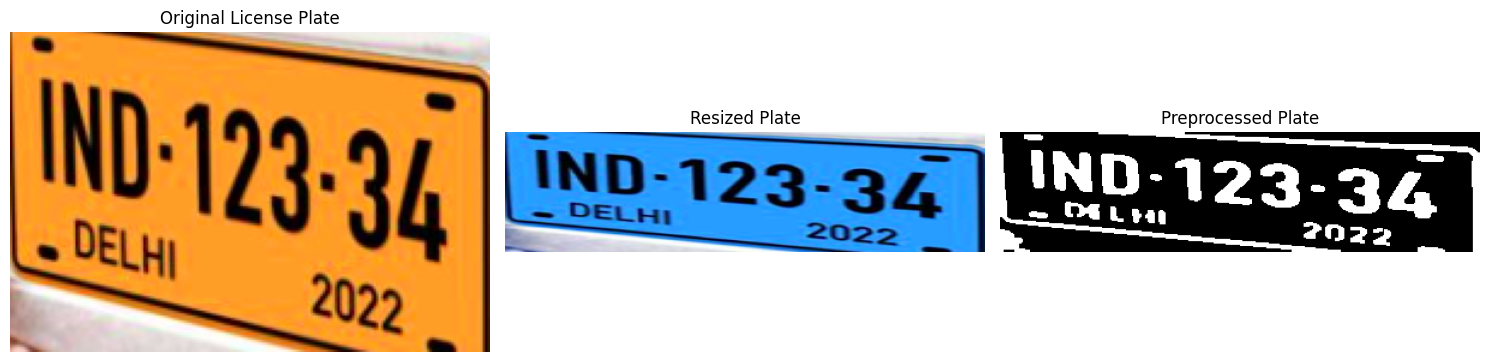

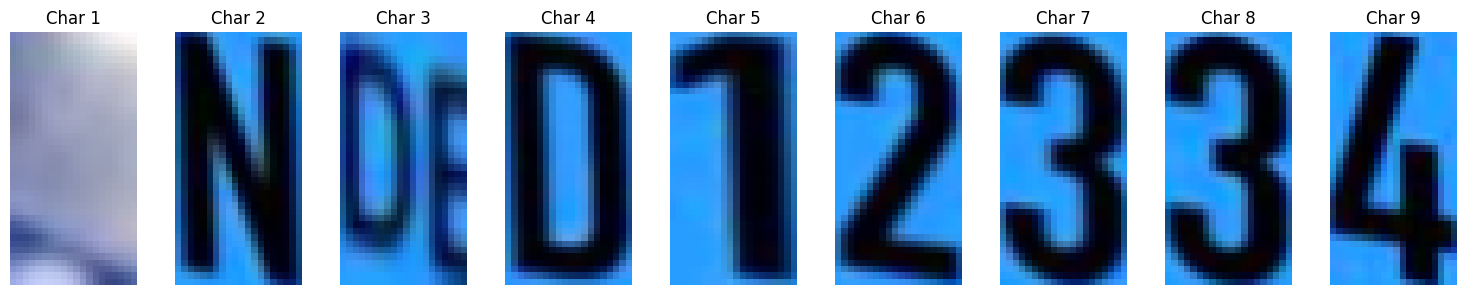

Number of characters detected: 9


In [6]:
# Load and process the license plate image
license_plate_img = cv2.imread('../images/input/plate3.png')

# Segment characters
char_images, resized_plate, preprocessed_plate = segment_characters(license_plate_img)

# Display results
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(cv2.cvtColor(license_plate_img, cv2.COLOR_BGR2RGB))
plt.title('Original License Plate')
plt.axis('off')

plt.subplot(132)
plt.imshow(resized_plate, cmap='gray')
plt.title('Resized Plate')
plt.axis('off')

plt.subplot(133)
plt.imshow(preprocessed_plate, cmap='gray')
plt.title('Preprocessed Plate')
plt.axis('off')

plt.tight_layout()
plt.show()

# Display segmented characters
plt.figure(figsize=(15, 3))
for i, char_img in enumerate(char_images):
    plt.subplot(1, len(char_images), i+1)
    plt.imshow(char_img, cmap='gray')
    plt.title(f'Char {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Number of characters detected: {len(char_images)}")